# imports

In [3]:
import sys
sys.path.append('../')

import numpy as np
import optuna
import torch
import pickle

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time

import matplotlib
import matplotlib.pyplot as plt
import ColorDataUtils.mattplotlib as mplt
from ColorDataUtils.multidata_utils import MultiExperiment
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

device = torch.device("cuda:1")
dtype = torch.float32

datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/'

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils


# testing NDN generate_predictions() 

In [2]:
# test when block_sample=False

# import NDNT.utils as utils # some other utilities
# import NDNT.NDNT as NDN
# from NDNT.modules.layers import *
# from NDNT.networks import *
# 
# # Load Data
# num_lags = 10
# expts = ['expt04']
# # this can handle multiple experiments
# #expts = ['expt04', 'expt05']
# 
# from NTdatasets.cumming.monocular import MultiDataset
# data = MultiDataset(
#     datadir='../Mdata/', filenames=expts, include_MUs=False,
#     time_embed=True, num_lags=num_lags )
# imagesc(data.dfs.detach().numpy())
# print("%d cells, %d time steps."%(data.NC, data.NT))
# 
# 
# adam_parsT = utils.create_optimizer_params(
#     optimizer_type='AdamW',
#     batch_size=2, # * 240 timesteps
#     num_workers=0,
#     learning_rate=0.0017,
#     early_stopping_patience=1,#4,
#     optimize_graph=False,
#     weight_decay=0.235,
#     max_epochs=1)
# adam_parsT['device'] = device
# 
# # setup
# data.device = device
# NCv = data.NC
# NT = data.robs.shape[0]
# 
# with open('cnn.pkl', 'rb') as f:
#     cnn = pickle.load(f)
#     
# print(cnn.block_sample)
# 
# np.unique([len(inds) for inds in data.block_inds])
# 
# cnn.generate_predictions(data, batch_size=2)

In [3]:
# test when block_sample=True

# num_lags=16
# expt_names = ['J220715']
# expts = MultiExperiment(expt_names)
# data, drift_terms, mu0s = expts.load(datadir,
#                                      num_lags=num_lags,
#                                      et_metric_thresh=0.8,
#                                      array_types=['UT'],
#                                      luminance_only=True)
# 
# class Model:
#     def __init__(self, ndn_model, LLs):
#         self.ndn = ndn_model
#         self.LLs = LLs
# 
# with open('../models/cnns_multi_06_1x_0715/cnn_0.pkl', 'rb') as f:
#     model_1x = pickle.load(f).ndn_model
# 
# model_1x.generate_predictions(data, batch_size=1)

# CNN model

## load models

In [16]:
from dataclasses import dataclass

class Model:
    def __init__(self, ndn_model, LLs):
        self.ndn = ndn_model
        self.LLs = LLs

@dataclass
class Mod:
    name: str
    NC: int
    model_1x: Model
    model_2x: Model
    readout_1x: np.array
    readout_2x: np.array
    layer_bounds_1x: list
    layer_bounds_2x: list

names = ['0715', '0722', '0808']
mods = []

for name in names:
    with open('../models/cnns_multi_08_1x_'+name+'/cnn_0.pkl', 'rb') as f:
        model_1x = pickle.load(f)
    with open('../models/cnns_multi_08_2x_'+name+'/cnn_0.pkl', 'rb') as f:
        model_2x = pickle.load(f)

    layer_bounds_1x, readout_1x = mplt.plot_readout_weights(model_1x.ndn_model, do_plot=False)
    layer_bounds_2x, readout_2x = mplt.plot_readout_weights(model_2x.ndn_model, do_plot=False)
    
    mods.append(Mod(name, len(model_1x.LLs),
                    model_1x, model_2x, 
                    readout_1x, readout_2x,
                    layer_bounds_1x, layer_bounds_2x))
    

for mod in mods:
    print(mod.name)
    print(np.mean(mod.model_1x.LLs), np.mean(mod.model_1x.LLs[:mod.NC//2]), np.mean(mod.model_1x.LLs[mod.NC//2-1:]))
    print()

0715
0.02959817 0.0333014 0.025189964

0722
0.016348863 0.015211674 0.017525068

0808
0.017635817 0.021881856 0.013319519


## compare LGN weights

In [ ]:
# get LGN weights
lgn_weights_1x = cnn_1x.networks[0].layers[0].get_weights()
lgn_weights_2x = cnn_2x.networks[0].layers[0].get_weights()
print(lgn_weights_1x.shape, lgn_weights_2x.shape)

# plot side-by-side and compare
lgn_max = np.max(lgn_weights_1x)
fig = plt.figure(figsize=(10,4))
grid = matplotlib.gridspec.GridSpec(nrows=1, ncols=4)
for i in range(4):
    ax = fig.add_subplot(grid[0, i])
    ax.imshow(lgn_weights_1x[:,:,7,i], interpolation='none', vmin=-lgn_max, vmax=lgn_max)

# plot side-by-side and compare
lgn_max = np.max(lgn_weights_2x)
fig = plt.figure(figsize=(10,4))
grid = matplotlib.gridspec.GridSpec(nrows=1, ncols=4)
for i in range(4):
    ax = fig.add_subplot(grid[0, i])
    ax.imshow(lgn_weights_2x[:,:,7,i], interpolation='none', vmin=-lgn_max, vmax=lgn_max)

## compare a couple neurons in the model with duplicate neurons

### 2 same and 1 diff

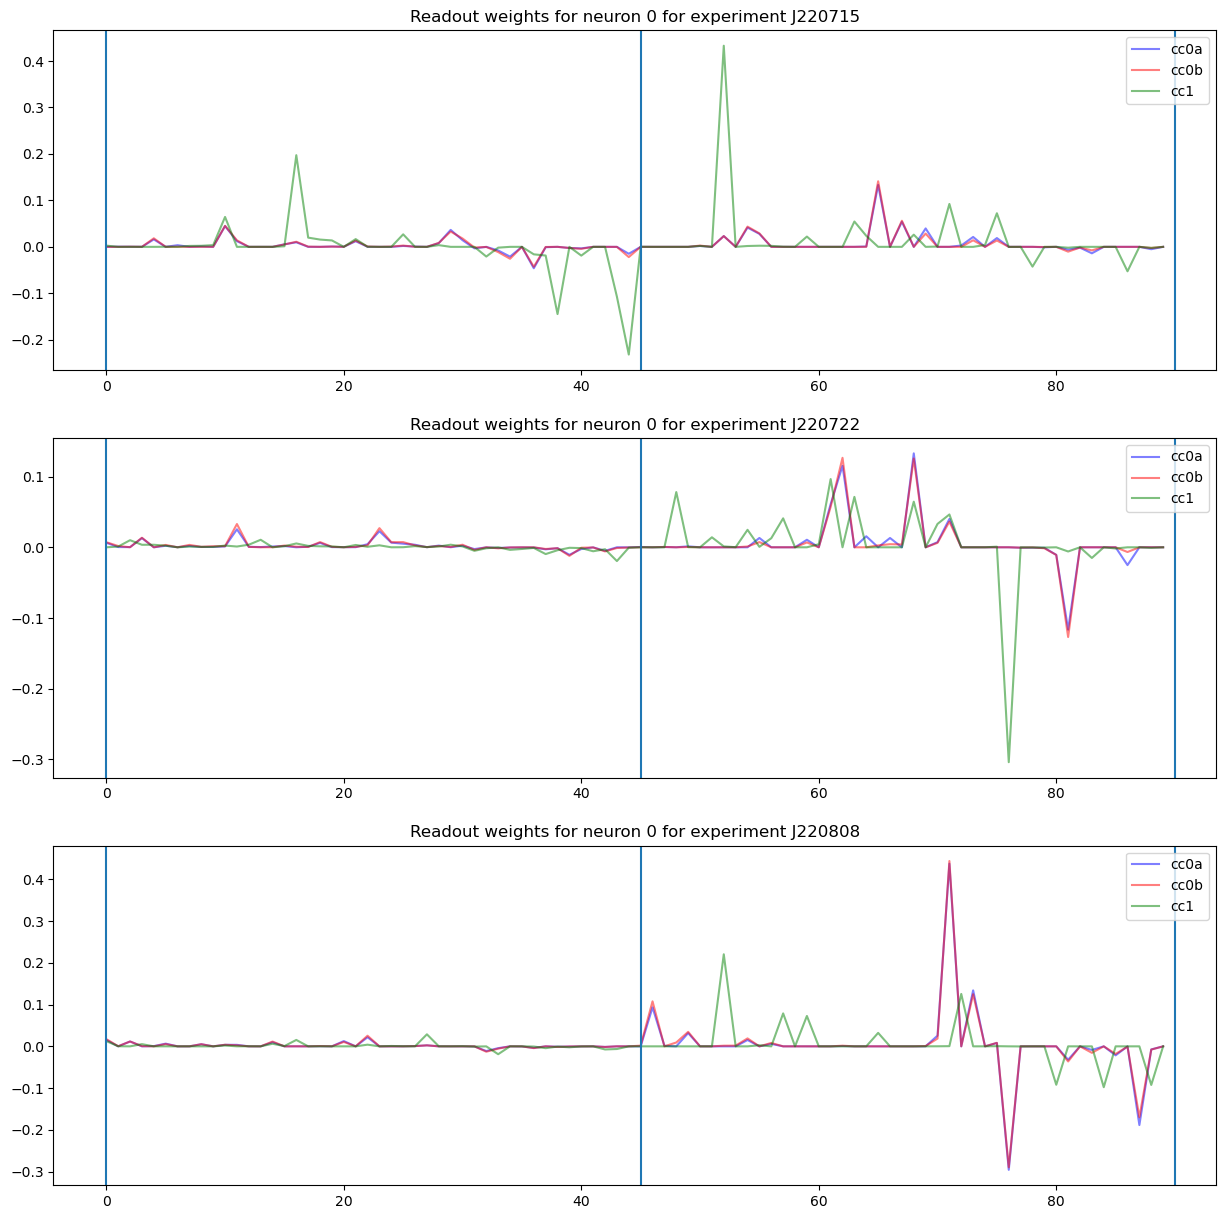

In [17]:
# compare 2 same and 1 diff for all 3 experiments
fig = plt.figure(figsize=(15, 15))
grid = matplotlib.gridspec.GridSpec(nrows=3, ncols=1)
for i, mod in enumerate(mods):
    neuron = 0
    ax = fig.add_subplot(grid[i,0])
    ax.plot(mod.readout_2x[:,neuron], label='cc0a', alpha=0.5, c='b')
    ax.plot(mod.readout_2x[:,neuron+mod.NC], label='cc0b', alpha=0.5, c='r')
    ax.plot(mod.readout_2x[:,neuron+1], label='cc1', alpha=0.5, c='g')
    plt.title('Readout weights for neuron '+str(neuron)+' for experiment J22'+mod.name)
    
    # add vertical lines for the mod.layer_bounds_1x
    for bound in mod.layer_bounds_2x:
        plt.axvline(x=bound)

    plt.legend()
plt.show()

### all similarity matrix

In [5]:
# calculate and plot similarity matrix for all 3 experiments
fig = plt.figure(figsize=(10, 30))
grid = matplotlib.gridspec.GridSpec(nrows=3, ncols=1)
for i, mod in enumerate(mods):
    ax = fig.add_subplot(grid[i,0])
    # calculate the similarity of weights between all neurons and make a plot
    corrmatrix = np.zeros((mod.NC, mod.NC))
    for cc0 in range(mod.NC):
        for cc1 in range(mod.NC, mod.NC*2):
            corrmatrix[cc0, cc1-mod.NC] = np.mean(np.abs(mod.readout_2x[:,cc0] - mod.readout_2x[:,cc1]))
    
    # set ticks
    ax.set_xticks(np.arange(0, mod.NC, 10), np.arange(0, mod.NC, 10))
    ax.set_yticks(np.arange(0, mod.NC, 10), np.arange(mod.NC, mod.NC*2, 10))
    ax.imshow(corrmatrix, interpolation='none', origin='lower', cmap='viridis')
    ax.set_xlabel('Neuron')
    ax.set_ylabel('Neuron')
    ax.set_title('Experiment J22'+mod.name)
plt.suptitle('Mean readout absolute difference between duplicate neurons')
# shift the figure up to leave a little rom for the suptitle
fig.subplots_adjust(top=0.95)
plt.show()

<Figure size 1000x3000 with 0 Axes>

# Iter model

## load models

In [24]:
import glob
fnames = []
models = []
for fname in glob.glob('../models/cnns_multi_06_2x_same/*.pkl'):
    if 'study' in fname:
        continue
    with open(fname, 'rb') as f:
        models.append(pickle.load(f))
        fnames.append(fname)
        
for fname,model in zip(fnames, models):
    print(fname, np.mean(model.LLs))

../models/cnns_multi_06_2x_same/cnn_0.pkl 0.033420995


In [4]:
class Model:
    def __init__(self, ndn_model, LLs):
        self.ndn = ndn_model
        self.LLs = LLs

import os
import pickle
with open(os.path.join('../models/cnns_multi_06/cnn_1.pkl'), 'rb') as f:
    model = pickle.load(f)